<a href="https://colab.research.google.com/github/MiguelCarbo/Anomalies-Detection-TFG/blob/main/3_Clustering_Basics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TFG - NON SUPERVISED LEARNING
## CLUSTERING
### Miguel Ivars Carbó, 795802@unizar.es
---
*Primer acercamiento al TFG.*  
*Se pretende implementar en este script, un mecanismo sencillo que permita implementar la técnica de Clustering como forma de análisis no supervisado y realizar así los primeros test dentro del marco de trabajo.*


In [ ]:
# Reset Variables
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [ ]:
# Packet Unzipping
!unzip zat.zip;

# Third Packet Imports
import pandas as pd;
import numpy as np;
import sklearn;
from sklearn.manifold import TSNE;
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis;
from sklearn.cluster import KMeans, DBSCAN;

# Local imports
import zat;
from zat.log_to_dataframe import LogToDataFrame;
from zat.dataframe_to_matrix import DataFrameToMatrix;

# Good to print out versions of stuff
print('ZAT: {:s}'.format(zat.__version__))
print('Pandas: {:s}'.format(pd.__version__))
print('Scikit Learn Version:', sklearn.__version__)

### 1. CHOOSING LOG TO CREATE DATAFRAME FROM ###

In [ ]:
# Create a Pandas dataframe from the Zeek log
log_to_df = LogToDataFrame();
conn_df = log_to_df.create_dataframe('conn.log');
conn_df.columns

Index(['uid', 'id.orig_h', 'id.orig_p', 'id.resp_h', 'id.resp_p', 'proto',
       'service', 'duration', 'orig_bytes', 'resp_bytes', 'conn_state',
       'local_orig', 'local_resp', 'missed_bytes', 'history', 'orig_pkts',
       'orig_ip_bytes', 'resp_pkts', 'resp_ip_bytes', 'tunnel_parents'],
      dtype='object')

In [ ]:
# Different Pandas Commands

# conn_df.head()
# conn_df.columns
# conn_df.index
# conn_df['id.orig_h'].head(10) 
# conn_df.iat[0, 0]                                           # Access element based on location
# conn_df.at['2023-02-06 07:54:51.884406016', 'history']      # Access element by label
# Al acceder por label, tambien hay que acceder a la fila por 'index' y no por posicion numerica

### Importante en PANDAS: filas se numeran por numero '0,1,...n' y por defecto, escoge indexacion por filas (axis = 0) ###
# Para marcar indexacion por columnas, hay que marcar axis=1

## Drop Colum ##
# new_conn_df = conn_df.drop(['uid'],axis=1)           
   
## Drop Row ##
### mucho cuidado si mi index es un timestamp ### 
# new_conn_df.drop(pd.Timestamp('2023-02-06 07:55:09.972538880'))

#### 2. FEATURE SELECTION ####
https://scikit-learn.org/stable/modules/feature_selection.html#feature-selection
https://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html#sphx-glr-auto-examples-ensemble-plot-forest-importances-py

#### 2.1.1  USING A FOREST OF TREES / BASED IN MEAN DECREASE IN IMPURITY ####

In [ ]:
## DUDA ##
# --- No puedo aplicar tecnicas de seleccion de parametros utilizando RF porque
# --- a la hora de entrenar los datos, no tengo 'target' 'y'. Se me queda
# --- cojo el modelo y no lo puedo utilizar. 
# --- ¿En estos caso, el taget qué debería ser?

from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.utils import Bunch as SKBunch
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

# convert the dataframe to a numpy array
np_conn_data = conn_df.to_numpy()

# create a scikit-learn dataset
sk_dataset = SKBunch(data=np_conn_data, target=None, feature_names=conn_df.columns)
X, y = sk_dataset.data, sk_dataset.target
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)    


#### 2.1.2 USING CORRELATION FEATURE ANALYSIS ####



In [ ]:
conn_df.replace('',0, inplace=True)
conn_df.head()
conn_df['tunnel_parents'] = conn_df['tunnel_parents'].astype('category')
conn_df.drop('local_orig', axis = 1)
conn_df.drop('local_resp', axis = 1)
# convert the categorical column to int type
conn_df['tunnel_parents'] = conn_df['tunnel_parents'].cat.codes
conn_df.fillna(0, inplace=True)

In [ ]:
conn_df.head(3)

# Data Preprocessing
label1 = 'duration'
label2 = 'orig_bytes'
label3 = 'resp_bytes'
label4 = 'local_orig'
label5 = 'local_resp'
label6 = 'missed_bytes'
label7 = 'tunnel_parents'

# list with feature names (V1, V2, V3, ...)
features = conn_df.columns.tolist()
features.remove(label1, label2, label3, label4, label5, label6, label7)

# change class labeling to 0 and 1
conn_df[label1] = np.where( conn_df[label1] > 1, 1, 0)

#### 2.1.3 WITHOUT PRIOR SELECTION #####

In [ ]:
# Pick some features that might be interesting
# some of the features are numerical and some are categorical
features = ['duration', 'orig_bytes', 'resp_bytes', 'missed_bytes', 'orig_ip_bytes', 'resp_ip_bytes'];

#### 2.2 MATRIX BUILDING BASED ON FEATURES ####

In [ ]:
# Use the DataframeToMatrix class (handles categorical data)
# You can see below it uses a heuristic to detect category data. When doing
# this for real we should explicitly convert before sending to the transformer.
to_matrix = DataFrameToMatrix();
conn_feature_matrix = to_matrix.fit_transform(conn_df[features], normalize=True);
conn_feature_matrix.shape

Normalizing column duration...
Normalizing column orig_bytes...
Normalizing column resp_bytes...
Normalizing column missed_bytes...
Cannot normalize series (div by 0) so not normalizing...
Normalizing column orig_ip_bytes...
Normalizing column resp_ip_bytes...


(13825, 6)

#### 2.3 DATA PREPROCESSING ####

In [ ]:
# Find for NaNs in matrix
indices = np.argwhere(np.isnan(conn_feature_matrix))
# The indices of NaN values
print(indices)

#### 2.4 PLOTTING DEFAULTS ####

In [ ]:
# Plotting defaults
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['font.size'] = 12.0
plt.rcParams['figure.figsize'] = 12.0, 6.0

### 3. CLUSTERING ###

### 3.1 K-MEANS ###

#### 3.1.1 SILHOUETTE SCORING ####
##### <i> Find most suited value of K </i> #####
<i>"The silhouette value is a measure of how similar an object is to its own cluster (cohesion) compared to other clusters (separation).</i>  

<i>The silhouette ranges from -1 to 1, where a high value indicates that the object is well matched to its own cluster and poorly matched to neighboring clusters.</i>  

<i>If most objects have a high value, then the clustering configuration is appropriate. If many points have a low or negative value, then the clustering configuration may have too many or too few clusters."</i>

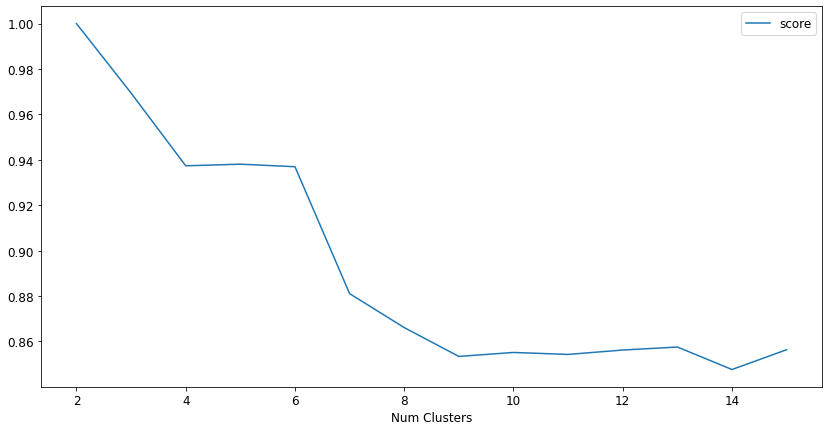

In [ ]:
from sklearn.metrics import silhouette_score

scores = []
clusters = range(2,16)

for K in clusters:
    clusterer = KMeans(n_clusters=K)
    cluster_labels = clusterer.fit_predict(conn_feature_matrix)
    score = silhouette_score(conn_feature_matrix, cluster_labels)
    scores.append(score)

# Plot it out
pd.DataFrame({'Num Clusters':clusters, 'score':scores}).plot(x='Num Clusters', y='score')

In [ ]:
# So we know that the highest (closest to 1) silhouette score is at 'm' clusters
kmeans_labels = KMeans(n_clusters=3).fit_predict(conn_feature_matrix);

# TSNE is a great projection algorithm. In this case we're going from 'n' dimensions to 2
projection = TSNE().fit_transform(conn_feature_matrix);

# Now we can put our ML results back onto our dataframe!
conn_df['cluster'] = kmeans_labels;
conn_df['x'] = projection[:, 0]; # Projection X Column
conn_df['y'] = projection[:, 1]; # Projection Y Column

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


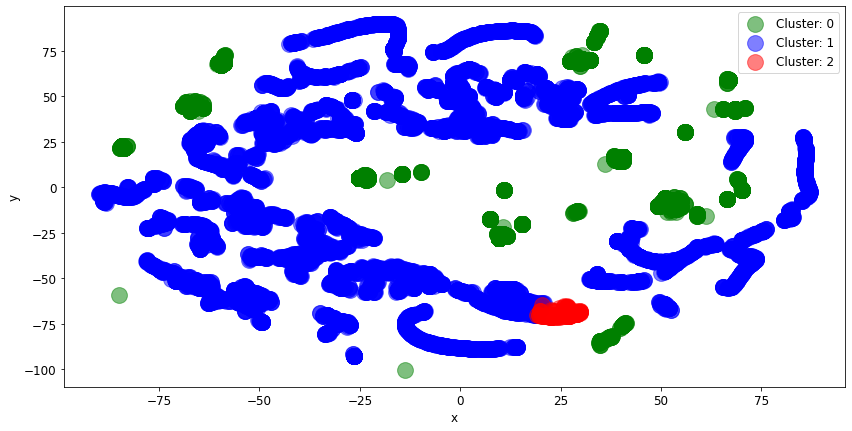

In [ ]:
# Now use dataframe group by cluster
cluster_groups = conn_df.groupby('cluster')

# Plot the Machine Learning results
colors = {-1:'black', 0:'green', 1:'blue', 2:'red'}
fig, ax = plt.subplots()
for key, group in cluster_groups:
    group.plot(ax=ax, kind='scatter', x='x', y='y', alpha=0.5, s=250,
               label='Cluster: {:d}'.format(key), color=colors[key])

In [ ]:
# Now print out the details for each cluster
pd.set_option('display.width', 1000)
for key, group in cluster_groups:
    print('\nCluster {:d}: {:d} observations'.format(key, len(group)))
    print(group[features].head())


Cluster 0: 6405 observations
                              duration  orig_bytes  resp_bytes  missed_bytes  orig_ip_bytes  resp_ip_bytes
ts                                                                                                        
2023-02-06 07:54:55.834434048      NaT        <NA>        <NA>             0             78              0
2023-02-06 07:54:55.940392960      NaT        <NA>        <NA>             0             78              0
2023-02-06 07:54:55.941020928      NaT        <NA>        <NA>             0             78              0
2023-02-06 07:54:56.147490048      NaT        <NA>        <NA>             0             78              0
2023-02-06 07:54:56.147490048      NaT        <NA>        <NA>             0             78              0

Cluster 1: 7298 observations
                                            duration  orig_bytes  resp_bytes  missed_bytes  orig_ip_bytes  resp_ip_bytes
ts                                                                    

#### 3.2 USING DBSCAN ####
<I>Density-based spatial clustering is a data clustering algorithm that given a set of points in space, groups points that are closely packed together and marking low-density regions as outliers.</i>  

<i>You don't have to pick K. There are other hyperparameters (eps and min_samples) but defaults often work well </i>

In [ ]:
# Now try DBScan
conn_df['cluster_db'] = DBSCAN().fit_predict(conn_feature_matrix)
print('Number of Clusters: {:d}'.format(conn_df['cluster_db'].nunique()))

Number of Clusters: 3


In [ ]:
# Now use dataframe group by cluster
cluster_groups_db = conn_df.groupby('cluster_db')

# Projection using TSNE or PCA algorithm
# projection = TSNE().fit_transform(conn_feature_matrix);

# conn_df['x'] = projection[:, 0]; # Projection X Column
# conn_df['y'] = projection[:, 1]; # Projection Y Column


colors = {-1:'green', 0:'blue', 2:'yellow'}

# Plot the Machine Learning results
fig, ax = plt.subplots()
for key, group in cluster_groups_db:
    group.plot(ax=ax, kind='scatter', x='x', y='y', alpha=0.5, s=250,
               label='Cluster_DB: {:d}'.format(key), color=colors[key])

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


KeyboardInterrupt: ignored

In [ ]:
# Now print out the details for each cluster
pd.set_option('display.width', 1000)
for key, group in cluster_groups:
    print('\nCluster {:d}: {:d} observations'.format(key, len(group)))
    print(group[features].head())


Cluster -1: 2 observations
                                            duration  orig_bytes  resp_bytes  missed_bytes  orig_ip_bytes  resp_ip_bytes
ts                                                                                                                      
2023-02-06 07:59:54.493336832 0 days 00:00:35.326455        1533    37016725             0         346057       38031257
2023-02-06 08:01:14.472413952 0 days 00:00:28.239606        1524    34579144             0         363612       35526916

Cluster 0: 7418 observations
                                            duration  orig_bytes  resp_bytes  missed_bytes  orig_ip_bytes  resp_ip_bytes
ts                                                                                                                      
2023-02-06 07:54:51.884406016 0 days 00:00:00.030683          35          85             0            287            289
2023-02-06 07:54:51.883755008 0 days 00:00:00.034385          35         299             0     